# Preprocessing Structured Data

Before we actually feed the data into any deep learning system we should look through it carefully. In addition to the kinds of big-picture problems that might arise in collecting data from a noisy world, we need to look out for missing values, strange outliers, and potential errors in the data. The data doesn't have to be completely error free, although obviously that would be best. Frequently, with the size of data we're dealing with, it is not realistic to completely scrub the data of any errors.

Once we have a collection of data that has a tolerable amount of errors (ideally error free, though that does not HAVE to be the case) we have to transform it into a deep learning friendly format. There are a number of tricks that machine learning practitioners apply to get better results from the same data.

It's also wise to explore the data and look for interesting outliers, correlation between different parts of the data, and other anomolies, oddities, and trends. Of course, we're hoping that our deep learning system can tease these out even better than we could—but that's not a good reason to shirk your own responsibility to understand the dataset. Sophisticated as they are, neural nets are still just tools, and understanding the data can help use hone our tools in the areas where they'll be most successful.

# Anonymized Student Risk Data

Some of the available risk indicator data on students may help provide insight on their ability to succeed. This data includes:

* Enrollment Holds - The count of times the student was not allowed to register due to administrative restrictions
* D/F/W Grades - The count if D/F/W grades in the entire student's history at PSU
* Unmet Financial Need - How much cost does a student with potential financial strain have to cover themselves
* First Generation - Is this student the first in their family to attend college
* Balance Due - Is this student in much debt to the university
* High School GPA
* PSU GPA Trend
* W/I Grades


In [1]:
# Pandas is a fantastic and powerful tool for working with structured data
# it's the best of spreadsheets + python, and it has quickly become a go to
# library for data scientists in python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your path may vary, change this appropriately
datasets = '../../../data'
path_to_stu_risk = f'{datasets}/raw/reduced_not_norm.csv'

# One of the things we love about pandas is that it's easy to load CSV data
# into a "data frame"
risk_df = pd.read_csv(path_to_stu_risk)

# And, it makes it easy to take a look at the first n items:
risk_df.head(5)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,HIGH_SCHOOL_GPA
0,1,NaN,1641.5,0.000,4.0,0,0,0,''
1,0,-2000.0,0.0,3.665,NaN,0,0,0,''
2,0,1274.0,0.0,4.000,0.0,5,3,0,''
3,0,NaN,281.0,4.000,4.0,0,0,0,'3.06'
4,0,NaN,0.0,0.000,4.0,6,11,0,''


In [2]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


Lets first try to understand the overall characteristics of the data including the total number of records and the completeness of fields

In [3]:
risk_df.describe()

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK
count,32167.000000,9230.000000,32167.000000,27042.000000,24845.000000,32167.000000,32167.000000,32167.000000
mean,0.109988,6276.253358,202.600652,2.892804,3.105437,0.692449,2.550129,0.304940
std,0.312880,8529.320937,797.185971,1.361592,1.097969,1.793794,4.374338,0.460389
min,0.000000,-43404.000000,-3488.290000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.443333,2.780000,0.000000,0.000000,0.000000
50%,0.000000,5008.000000,0.000000,3.466333,3.500000,0.000000,0.000000,0.000000
75%,0.000000,11329.500000,0.000000,4.000000,3.934000,1.000000,3.000000,1.000000
max,1.000000,49745.000000,19475.000000,4.000000,4.000000,58.000000,59.000000,1.000000


One obvious issue apparent in the summary is the differenece between the count of total students (32167) and the count of those that have a previous GPA (24845). Are these students without a previous GPA new students? The remaining fields describe the history of a student, and for new students, we will not have those historical fields. Using PSU history to predict a future outcome will not make sense for new students. Let's check the assumption that students without a previous GPA are also missing other historical fields

In [4]:
is_new_df = risk_df[pd.isnull(risk_df.PREV_GPA)]
is_new_df.describe()

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK
count,7322.000000,1021.000000,7322.000000,2197.000000,0.0,7322.000000,7322.000000,7322.000000
mean,0.094373,2326.497884,150.015829,2.696049,NaN,0.048211,0.903305,0.305381
std,0.292367,4729.950390,774.709684,1.496902,NaN,0.317065,2.291952,0.460600
min,0.000000,-17000.000000,-1939.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.833333,NaN,0.000000,0.000000,0.000000
50%,0.000000,250.000000,0.000000,3.333333,NaN,0.000000,0.000000,0.000000
75%,0.000000,3736.000000,0.000000,4.000000,NaN,0.000000,1.000000,1.000000
max,1.000000,29807.000000,13426.250000,4.000000,NaN,5.000000,31.000000,1.000000


The rest of the historical fields appear to have reasonable information for the students without a previous GPA. The previous GPA in fact is not reported in this data set if a student hadn't taken a class in the previous two terms. One method to allow these two cases (existing previous GPA and having a gap in attendence) to coexist is to relax the previous single GPA value into GPA categories plus a gap category

# Success Conditions

The objective of our model is to predict a students future (LAST_GPA) grade. Looking at the following correlation matrix, the PREV_GPA, DFW_GRADE_COUNT, and REG_HOLD_RISK have the strongest correlation with LAST_GPA. One measure of success for our model is if it can predict the future GPA (LAST_GPA) better than just using PREV_GPA as a predictor

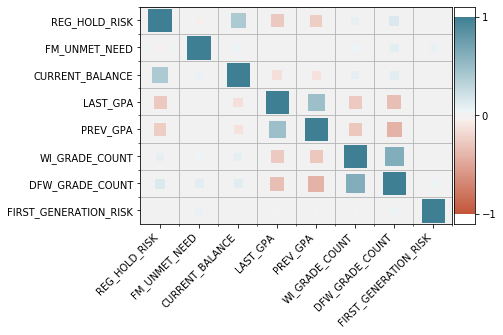

In [5]:
corrplot(risk_df.corr())

In [6]:
# Using the College Board grading scale division point values: https://pages.collegeboard.org/how-to-convert-gpa-4.0-scale
#                    0     1   2     3    4    5    6    7    8   9     10   11 is Attendence gap
#                    F     D   D+    C-   C    C+   B-   B    B+  A-    A
grade_interval = [0.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0, 4.1]
grade_decode = {
    0: "F",  1: "D", 2: "D+", 3: "C-", 4: "C",
    5: "C+", 6: "B-", 7: "B", 8: "B+", 9: "A-", 10: "A"
}
bined_prev_gpa = pd.cut(risk_df.PREV_GPA, grade_interval, right=False, labels=False)
bined_prev_gpa = bined_prev_gpa.fillna(value=11.0)
bined_prev_gpa = bined_prev_gpa.astype(int)
risk_gpa_df = risk_df.copy()
risk_gpa_df.PREV_GPA = bined_prev_gpa
risk_gpa_df.describe()
# bined_prev_gpa.head(20)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK
count,32167.000000,9230.000000,32167.000000,27042.000000,32167.000000,32167.000000,32167.000000,32167.000000
mean,0.109988,6276.253358,202.600652,2.892804,8.002425,0.692449,2.550129,0.304940
std,0.312880,8529.320937,797.185971,1.361592,3.054022,1.793794,4.374338,0.460389
min,0.000000,-43404.000000,-3488.290000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.443333,7.000000,0.000000,0.000000,0.000000
50%,0.000000,5008.000000,0.000000,3.466333,9.000000,0.000000,0.000000,0.000000
75%,0.000000,11329.500000,0.000000,4.000000,10.000000,1.000000,3.000000,1.000000
max,1.000000,49745.000000,19475.000000,4.000000,11.000000,58.000000,59.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe94c788e90>]],
      dtype=object)

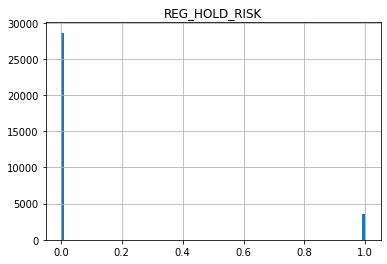

In [7]:
risk_gpa_df.hist(column='REG_HOLD_RISK', bins=100)

The negative FM_UNMET_NEED values seem off. Lets explore ..

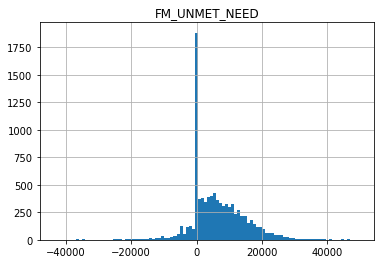

In [8]:
risk_gpa_df.hist(column='FM_UNMET_NEED', bins=100)
plt.show()

Assuming that negative values for unmet need indicate that those students are spending below the amount allocated to them for their financial aid. If that is the case, then the negative values are reasonable.

# Current Balance

Lets look at the current balance. There do not seem to be many people with an existing high balance, but those with an existing balance may be exactly the group which would benefit most with intervention. Let's look at students with a balance more than $1000

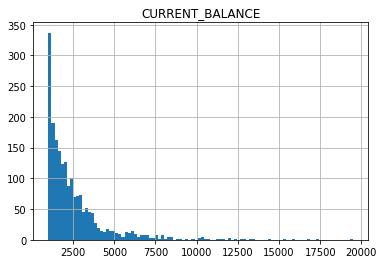

In [9]:
risk_gpa_df[risk_gpa_df['CURRENT_BALANCE'] > 1000].hist(column='CURRENT_BALANCE', bins=100)
plt.show()

There are definitly hundreds, and $1000 is a lot for a student 

# Output Data Preprocessing

Now let's format the our output data, which is the "LAST_GPA" data. For the coarse detail model, we want only to classify whether the student is successful or not (will they pass or not-pass). For PSU a GPA below a C- (1.7) is not passing. The category values: 0 represents not passing, 1 represents passing. The no LAST_GPA is considered not passing and is set to 0.

In [10]:
bined_last_gpa = pd.cut(risk_df.LAST_GPA, [0,1.7,4.1], right=False, labels=False)
bined_last_gpa = bined_last_gpa.fillna(value=0)
bined_last_gpa = bined_last_gpa.astype(int)
bined_last_gpa.head(20)
risk_gpa_out_df = risk_gpa_df.copy()
risk_gpa_out_df.LAST_GPA = bined_last_gpa
r = pd.DataFrame([risk_gpa_out_df.LAST_GPA, risk_df.LAST_GPA])
r.head(20)
#risk_gpa_out_df.LAST_GPA.head(30)
#risk_gpa_df.head(10)
#risk_df.LAST_GPA.head(20)

,0,1,2,3,4,5,6,7,8,9,...,32157,32158,32159,32160,32161,32162,32163,32164,32165,32166
LAST_GPA,0.0,1.000,1.0,1.0,0.0,1.000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LAST_GPA,0.0,3.665,4.0,4.0,0.0,3.665,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Success Verification Data

Encoding the feature with the highest correlation to our desired output. If the high correlation feature is close to predicting the desired outcome compared to our model, then our model is not neccessary.

In [11]:
prev_gpa = pd.cut(risk_df.PREV_GPA, [0,1.7,4.1], right=False, labels=False)
prev_gpa = prev_gpa.fillna(value=0)
prev_gpa = prev_gpa.astype(int)
prev_gpa = pd.DataFrame({'PREV_GPA': prev_gpa})

r = pd.DataFrame([prev_gpa.PREV_GPA, risk_df.PREV_GPA])
r.head(20)

,0,1,2,3,4,5,6,7,8,9,...,32157,32158,32159,32160,32161,32162,32163,32164,32165,32166
PREV_GPA,1.0,0.0,0.0,1.0,1.0,1.0,1.00,1.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PREV_GPA,4.0,NaN,0.0,4.0,4.0,4.0,3.67,3.428571,4.0,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# High School GPA

The high school gpa data is in string form. Let's explore the HS gpa and try to convert that into a format which could provide insight

In [12]:
hsgpa = risk_gpa_out_df.HIGH_SCHOOL_GPA
# The CSV importer brings in quoted values as string type with quote characters included, striping those off here
hsgpa = hsgpa.apply(lambda x: x.split("'")[1])
hsgpa = pd.to_numeric(hsgpa, errors='coerce')
hsgpa.describe()
#hsgpa.head(5)

count    14619.000000
mean         3.473586
std         11.470133
min          0.000000
25%          3.000000
50%          3.330000
75%          3.640000
max        688.000000
Name: HIGH_SCHOOL_GPA, dtype: float64

GPA values above 4.0 (like 688 above) don't make sense. Counting values greater than 4.0 as NaN

In [13]:
hsgpa = hsgpa.apply(lambda x: np.NaN if x > 4.0 else x)
hsgpa.describe()

count    14595.000000
mean         3.242492
std          0.602344
min          0.000000
25%          3.000000
50%          3.330000
75%          3.640000
max          4.000000
Name: HIGH_SCHOOL_GPA, dtype: float64

The values are now reasonable, but the data still contains NaNs for students who do not have high school GPA data. Using the same technique we used for PREV_GPA and converting GPA to categorical values, including no-hs-gpa-provided case.

In [14]:
hsgpa = pd.cut(hsgpa, grade_interval, right=False, labels=False)
hsgpa = hsgpa.fillna(value=11.0)
hsgpa = hsgpa.astype(int)
risk_gpa_out_hs_df = risk_gpa_out_df.copy()
risk_gpa_out_hs_df.HIGH_SCHOOL_GPA = hsgpa
risk_gpa_out_hs_df.describe()
#risk_gpa_out_hs_df.head(20)

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,HIGH_SCHOOL_GPA
count,32167.000000,9230.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000
mean,0.109988,6276.253358,202.600652,0.682967,8.002425,0.692449,2.550129,0.304940,9.311904
std,0.312880,8529.320937,797.185971,0.465328,3.054022,1.793794,4.374338,0.460389,2.161410
min,0.000000,-43404.000000,-3488.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,8.000000
50%,0.000000,5008.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,11.000000
75%,0.000000,11329.500000,0.000000,1.000000,10.000000,1.000000,3.000000,1.000000,11.000000
max,1.000000,49745.000000,19475.000000,1.000000,11.000000,58.000000,59.000000,1.000000,11.000000


In [16]:
# The last field with missing values is FM_UNMET_NEED. Converting NaNs to 0.0 to indicate there is no unmet need when equal to zero
risk_gpa_out_hs_df.FM_UNMET_NEED = risk_gpa_out_hs_df.FM_UNMET_NEED.fillna(0.0)
# Writing out our preprocessed data. The next step will convert the data into the form which can be consumed by our model
path_to_stu_risk = f'{datasets}/interim/01-preprocess-structured-data-coarse.csv'
risk_gpa_out_hs_df.to_csv(path_to_stu_risk, index=False)
prev_gpa.to_csv(f'{datasets}/interim/prev-gpa-coarse.csv', index=False)
risk_gpa_out_hs_df.describe()

,REG_HOLD_RISK,FM_UNMET_NEED,CURRENT_BALANCE,LAST_GPA,PREV_GPA,WI_GRADE_COUNT,DFW_GRADE_COUNT,FIRST_GENERATION_RISK,HIGH_SCHOOL_GPA
count,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000,32167.000000
mean,0.109988,1800.908337,202.600652,0.682967,8.002425,0.692449,2.550129,0.304940,9.311904
std,0.312880,5378.941805,797.185971,0.465328,3.054022,1.793794,4.374338,0.460389,2.161410
min,0.000000,-43404.000000,-3488.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,8.000000
50%,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,11.000000
75%,0.000000,0.000000,0.000000,1.000000,10.000000,1.000000,3.000000,1.000000,11.000000
max,1.000000,49745.000000,19475.000000,1.000000,11.000000,58.000000,59.000000,1.000000,11.000000
